# Synthetic Glacier: Geometry Generation 

Lets extract some data along an extended flowline for our Synthetic Glacier. Information we will extract:  
  * Surface profile from SRTM DEM,  
  * Bedrock profile from Faranotti et al. 2019

In [1]:
import os
import numpy as np
import geopandas as gpd
import contextily as ctx
import cartopy.crs as ccrs

import pickle 
import scipy.signal as signal
from scipy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import fiona
import rasterio
import rasterio.mask
from rasterio.io import MemoryFile
from rasterio.transform import Affine

# Set global matplotlib style parameters
plt.rcParams.update({'font.size': 14, 
                     'text.usetex': True, 
                     'figure.facecolor': 'w'})

In [2]:
def centerline_2_points(geom, dx=30):
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    num_vert = int(round(geom.length / dx))
    if num_vert == 0: 
        num_vert = 1
    multipoint = [geom.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)] 
    Latx = [multipoint[i].x for i in range(len(multipoint))]
    Laty = [multipoint[i].y for i in range(len(multipoint))]
    gdf  = gpd.GeoDataFrame(geometry=gpd.points_from_xy(Latx,Laty))
    return gdf

def lstq(x,y,order):
    A     = np.vstack([x**i for i in range(0,order)]).T
    coefs = LA.lstsq(A,y)[0]
    return coefs

In [3]:
EB_2007_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/EB/dem_2007.tif'
BED_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_BDEM.tif'
SRTM_fp    = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/SRTM/AST_merge/ASTGTMV003_MERGED_UTM7N.tif'
GC_Surf_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/surface_DEM_RGI60-01.16198.tif'

# Alternative Version of the Bed (05/12/2021)

In [4]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'

# What tributary are we looking at?
SURGE_TRIB = True

if SURGE_TRIB:
    #FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')
    FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N_extended.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL[LK_FL['MAIN'] == 1], dx=10)
    # For whatever reason we need to flip the oggm flowline
    LK_CP = LK_CP.sort_index(axis=0,ascending=False).reset_index(drop=True)
else:
    FL_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL, dx=10)

LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]

In [5]:
with rasterio.open(EB_2007_fp) as src:
    LK_CP['EB_2007'] = [x for x in src.sample(prof_coords)]
    LK_CP['EB_2007'] = LK_CP.apply(lambda x: x['EB_2007'][0], axis=1)

with rasterio.open(SRTM_fp) as src:
    LK_CP['SRTM'] = [x for x in src.sample(prof_coords)]
    LK_CP['SRTM'] = LK_CP.apply(lambda x: x['SRTM'][0], axis=1)

with rasterio.open(GC_Surf_fp) as src:
    LK_CP['GC_Surf'] = [x for x in src.sample(prof_coords)]
    LK_CP['GC_Surf'] = LK_CP.apply(lambda x: x['GC_Surf'][0], axis=1)
    
with rasterio.open(BED_DEM_fp) as src:
    bed_nodata = src.nodata
    LK_CP['bedprof'] = [x for x in src.sample(prof_coords)]
    LK_CP['bedprof'] = LK_CP.apply(lambda x: x['bedprof'][0], axis=1)

# Replace nodata with np.nan
LK_CP = LK_CP.replace([-9999.0, 0.0, bed_nodata],np.nan)


In [6]:
# x-coordinate in km 
x_dx10 = LK_CP.index.to_numpy() * 10.0 / 1000.0

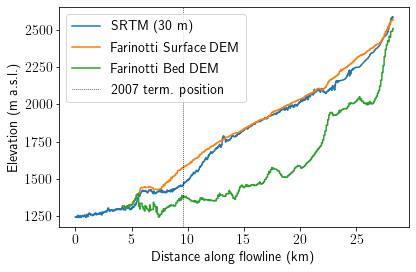

In [7]:
fig, ax = plt.subplots()

# ax.plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax.plot(x_dx10, LK_CP['SRTM']   , label='SRTM (30 m)')
ax.plot(x_dx10, LK_CP['GC_Surf'], label='Farinotti Surface DEM')
ax.plot(x_dx10, LK_CP['bedprof'], label='Farinotti Bed DEM')

ax.set_ylabel('Elevation (m a.s.l.)')
ax.set_xlabel('Distance along flowline (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

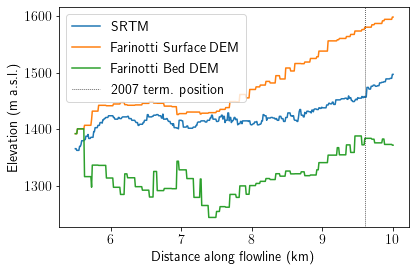

In [8]:
fig, ax = plt.subplots()

# ax.plot(x_dx10[550:1001], LK_CP['EB_2007'][550:1001], label='EB 2007 DEM')
ax.plot(x_dx10[550:1001], LK_CP['SRTM'][550:1001]   , label='SRTM')
ax.plot(x_dx10[550:1001], LK_CP['GC_Surf'][550:1001], label='Farinotti Surface DEM')
ax.plot(x_dx10[550:1001], LK_CP['bedprof'][550:1001], label='Farinotti Bed DEM')

ax.set_ylabel('Elevation (m a.s.l.)')
ax.set_xlabel('Distance along flowline (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

In [9]:
ss_poly   = np.polyval( np.polyfit(x_dx10, LK_CP['SRTM'], 10), x_dx10)
ss_smooth = signal.savgol_filter( x=LK_CP['SRTM'],   window_length=211, polyorder=5)
bb_smooth = signal.savgol_filter( x=LK_CP['bedprof'],window_length=211, polyorder=5)

correction = np.mean(ss_smooth[550:1001] - bb_smooth[550:1001])

In [17]:
correction

104.06190228925038

In [10]:
ss_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], ss_poly[x_dx10 > 9.0]])
bb_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], (bb_smooth + correction)[x_dx10 > 9.0]])

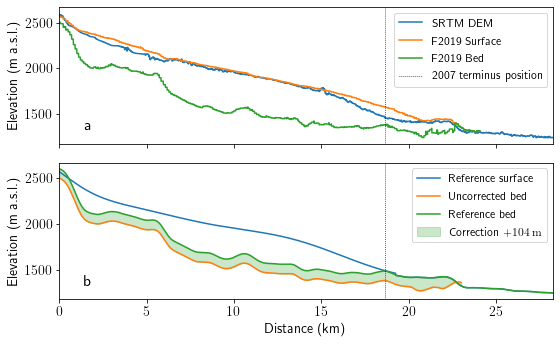

In [26]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

# ax[0].plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax[0].plot(x_dx10[::-1], LK_CP['SRTM']   , label='SRTM DEM')
ax[0].plot(x_dx10[::-1], LK_CP['GC_Surf'], label='F2019 Surface')
ax[0].plot(x_dx10[::-1], LK_CP['bedprof'], label='F2019 Bed')

ax[0].set_ylabel('Elevation (m a.s.l.)')

ax[0].axvline(x_dx10[-1] - 9.6, label='2007 terminus position',c='k', ls=':', lw=0.75)
ax[0].legend(fontsize='small')
ax[0].text(0.05, 0.1, 'a', transform=ax[0].transAxes, 
               fontsize=16, fontweight='bold')

ax[1].plot(x_dx10[::-1], ss_prop,  label='Reference surface')
ax[1].plot(x_dx10[::-1], bb_smooth,label='Uncorrected bed')
ax[1].plot(x_dx10[::-1], bb_prop,  label='Reference bed')
ax[1].fill_between(x_dx10[::-1], 
                 bb_smooth, bb_prop, 
                 color='tab:green', alpha=0.25, 
                 label=r'Correction $+104 \; \rm{m}$')

# np.concatenate([ss_smooth[x_coord < 9.0], (bb + correction)[x_coord >= 9.0]])
ax[1].set_ylabel('Elevation (m a.s.l.)')
ax[1].set_xlabel('Distance (km)')

ax[1].axvline(x_dx10[-1] - 9.6,  c='k', ls=':', lw=0.75)
# ax[1].axvline(x_dx10[-1] - 27.7, label='New maximum extent',  c='r', ls='--', lw=0.75)

ax[1].set_xlim(x_dx10[0], x_dx10[-1])
ax[1].legend(fontsize='small')
ax[1].text(0.05, 0.1, 'b', transform=ax[1].transAxes, 
               fontsize=16, fontweight='bold')
plt.tight_layout()

fig.savefig('../plots/GeometryGeneration.pdf',bbox_inches='tight')

In [12]:
xx  = np.linspace(x_dx10.min()*1e3,x_dx10.max()*1e3,x_dx10.shape[0])

# Chop off the upper portion where ice-thickness would be zero
ss_new = ss_prop[:2770]
bb_new = bb_prop[:2770]
xx_new = xx[:2770]


np.savetxt('../Data/Topography/REF_BedTopo.dat'   , np.array([xx_new,bb_new]).T,fmt='%.3e')
np.savetxt('../Data/Topography/REF_SurfTopo.dat'  , np.array([xx_new,ss_new]).T,fmt='%.3e')

## Harmonic Perturbations 

Following [Gudmundsson 2003](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002JB002107), let's define our bed $z_{\rm b}$ as: 

$$
z_{\rm b}(x) = z_{\rm b_{\rm F}} + z_{\rm b}'
$$

where $z_{\rm b}$ is synthetic bed profile as a function of distance along the flowline, $z_{\rm b_{\rm F}}$ is the observed Farinotti bed (in this case smoothed), and $z_{\rm b}'$ is our pertubation. 

Pertubations will take the form:
$$
z_{\rm b}' = \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)
$$
where, $A_{k}$ is amplitude of the $k$-th harmonic and $\bar H$ is the mean ice-thickness. 

In [13]:
# Let's load the (reference) surface and bed profiles we just wrote to disk
x     = np.loadtxt("../Data/Topography/REF_BedTopo.dat" )[:,0]
z_b   = np.loadtxt("../Data/Topography/REF_BedTopo.dat" )[:,1]
z_s   = np.loadtxt("../Data/Topography/REF_SurfTopo.dat")[:,1]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET PARAMETER VALUES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
H_bar = 100                    # Characteristic ice-thickness [ m ]
R     = 0.01                   # Amplitude to Wavelength Ratio
k_min = 5                      # Minimum harmonic
k_max = 15                     # Maximum harmonic
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET INPUT DATA
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
dx    = x[1] - x[0]            # horizontal gridcell spacing
M     = x.shape[0]             # Length of x-vec
N     = (k_max - k_min) + 2    # Number of harmonics to compute
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATE OUTPUT DATA
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
synth = np.zeros((M,N))        # DIM 0: x coordinate, DIM 1: k harmnoics
pxx   = np.zeros((M//2 + 1,N)) # DIM 0: wavenumbers, DIM 1: k harmnoics

In [14]:
# Itterate over the harmonics
for j, k in enumerate(np.arange(k_min,k_max+1)):
    λ = k * H_bar              # [m] Wavelength 
    A = R * λ                  # [m] Amplitude of k-th harmonic

    # Compute the k-th harmonic
    synth[:,j]  = A*np.sin(((2*np.pi)/λ)*x)

    # Compute the periodogram of the k-th harmonic
    f, pxx[:,j] = signal.periodogram(synth[:,j], fs=1/dx, scaling='spectrum')
    
# After Looping over all the harmonics, compute the sum of the series 
synth[:, j+1] = np.sum(synth[:,:j], axis=1)
# Compute the periodogram of the summ of all the harmonics
f, pxx[:,j+1] = signal.periodogram(synth[:,j+1], fs=1/dx, scaling='spectrum')

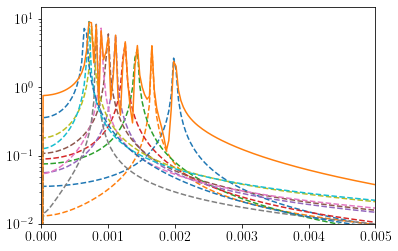

In [15]:
fig, ax = plt.subplots()

for j, k in enumerate(np.arange(k_min,k_max+1)):
    
    ax.plot(f, np.sqrt(pxx[:,j]), ls='--')
    
ax.plot(f, np.sqrt(pxx[:,j+1]))

    
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_ylim(10e-3,15);
ax.set_xlim(0, 0.005);

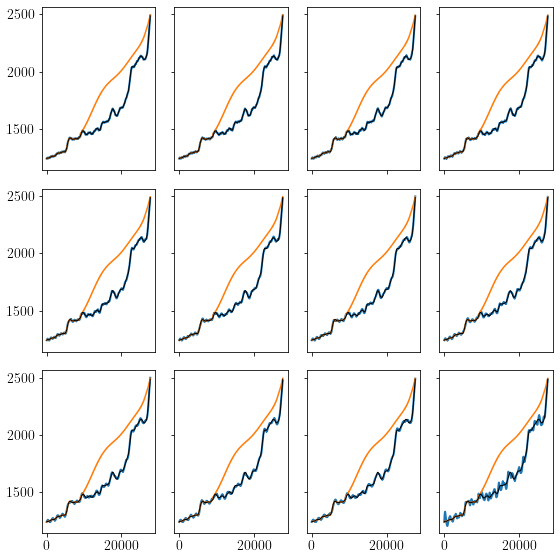

In [16]:
fig, axes = plt.subplots(3,4, figsize=(8,8), sharex=True, sharey=True)

for i,ax in enumerate(axes.ravel()): 
    
    if i < 13:
        ax.plot(x, z_b + synth[:,i], lw=2.0)
        ax.plot(x, z_s)
        ax.plot(x, z_b, lw=1.0, c='k')

plt.tight_layout()

fig.savefig('/Users/andrewnolan/Desktop/test.pdf', bbox_inches='tight')

In [ ]:
k*H_bar